In [30]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import pyexasol
import plotly.express as px
import seaborn as sns
from sklearn import preprocessing

In [96]:
cred = pd.read_json(r'/Users/skostuchik/crd_exa.json')
user = cred.iloc[0, 0]
password = cred.iloc[0, 1]

C = pyexasol.connect(dsn='ex1..3.city-srv.ru:8563', user=user, password=password, fetch_dict=True)

In [97]:
ar_query = f'''
with s as (
    select s.ID_DRIVER,
           sum(case when s."ACTION" in (1,-2) then 1 else 0 end) accept,
           count(s.ID) suggest
    from REPLICA.FAIRBOT_SUGGESTS_SUCCESS s
    where to_date(s.DATE_SUGGEST) between '2021-04-20' and '2021-06-20'
        and s.SUGGEST_TYPE = 4
    group by 1),
sh as (
    select DRIVER_RK, cast(ZEROIFNULL(SUM(DRIVER_STAY_DUR_SEC)/3600) as float) supply_hours,
       cast(ZEROIFNULL(SUM(case when STATE_TCD = 1 then DRIVER_STAY_DUR_SEC end)/3600) as float) open_state,
       cast(ZEROIFNULL(SUM(case when STATE_TCD = 2 then DRIVER_STAY_DUR_SEC end)/3600) as float) en_route_state,
       cast(ZEROIFNULL(SUM(case when STATE_TCD = 3 then DRIVER_STAY_DUR_SEC end)/3600) as float) on_trip_state
    from REPLICA_MART.DRIVER_MOVING_AGG_DAILY
    where STATE_TCD in (1,2,3)
      and DRIVER_ROBOT_CD != 0
        and BUSINESS_DT between '2021-04-20' and '2021-06-20'
    group by 1),
o as (
    select o.DRIVER_RK,
           cast(ZEROIFNULL(SUM(ic.driver_bill_amt +ic.di_mfg + ic.di_welcome_dxgy + ic.di_power_dxgy
               + ic.di_other_dxgy + ic.di_main_dxgy+ ic.di_guaranteed_amt_per_hour)) as float) money,
        cast(ZEROIFNULL(sum(case when o.STATUS_CD='CP' then 1 else 0 end)) as float) trips,
        cast(ZEROIFNULL(sum(ic.DI_TOTAL_AMT)) as float) DI_TOTAL_AMT
    from EMART."ORDER" o
    left join replica_mart.incentive_comission ic on o.order_rk = ic.ORDER_ID
    WHERE to_date(o.LOCAL_ORDER_DTTM) between '2021-04-20' and '2021-06-20'
    group by 1)
select d.ID_LOCALITY LOCALITY_RK, l.short_name LOCALITY_NM, o.DRIVER_RK, o.money, sh.supply_hours,
       o.money/sh.supply_hours MpH_Gross, trips, trips/sh.supply_hours TpH,
       s.accept, s.suggest, s.accept / s.suggest AR,
       o.DI_TOTAL_AMT,
       sh.open_state, sh.en_route_state, sh.on_trip_state
from o
join REPLICA.DRIVERS d on d.ID = o.DRIVER_RK
left join md.LOCALITY l on l.LOCALITY_RK = d.ID_LOCALITY
left join sh on sh.DRIVER_RK = o.DRIVER_RK
left join s on s.ID_DRIVER = o.DRIVER_RK
'''

In [98]:
e_ar = C.execute(ar_query)

In [99]:
df = pd.DataFrame(e_ar.fetchall())

In [101]:
df.dropna(inplace=True)

In [102]:
df['AR_bins'] = df['AR'].apply(lambda x: round(x,1))

In [103]:
ttl_data = df.groupby('AR_bins').agg({'DRIVER_RK':'count','TRIPS':'sum',
                                      'MPH_GROSS':'median','MONEY':'sum','SUPPLY_HOURS':'sum',
                                      'TPH':'median','DI_TOTAL_AMT':'sum'}).reset_index()

In [104]:
ttl_data['TPH_upd'] = np.divide(ttl_data['TRIPS'], ttl_data['SUPPLY_HOURS'])
ttl_data['MPH'] = np.divide(ttl_data['MONEY'], ttl_data['SUPPLY_HOURS'])
ttl_data['money_per_driver'] = np.divide(ttl_data['MONEY'], ttl_data['DRIVER_RK'])
ttl_data['DI_per_driver'] = np.divide(ttl_data['DI_TOTAL_AMT'], ttl_data['DRIVER_RK'])
ttl_data['TPD'] = np.divide(ttl_data['TRIPS'], ttl_data['DRIVER_RK'])

Text(0.5, 1.0, 'MPH & TPD by AR bins')

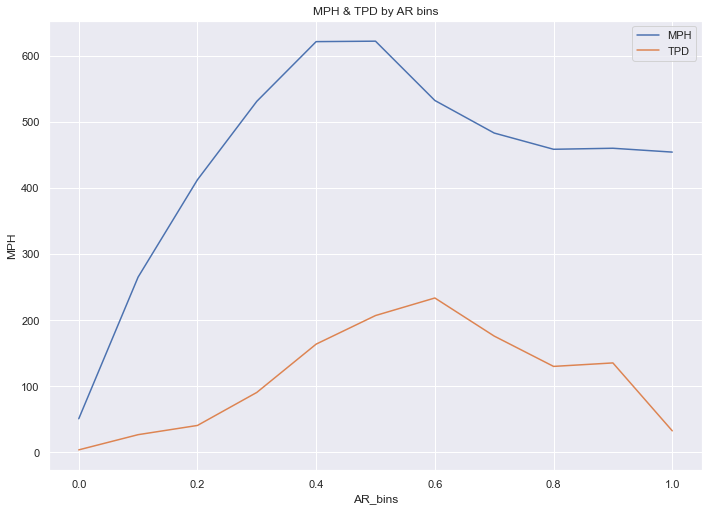

In [105]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(data=ttl_data, x="AR_bins", y="MPH", label="MPH")
sns.lineplot(data=ttl_data, x="AR_bins", y="TPD", label="TPD").set_title("MPH & TPD by AR bins")

Text(0.5, 1.0, 'Money per Driver and DI per Driver by AR bins')

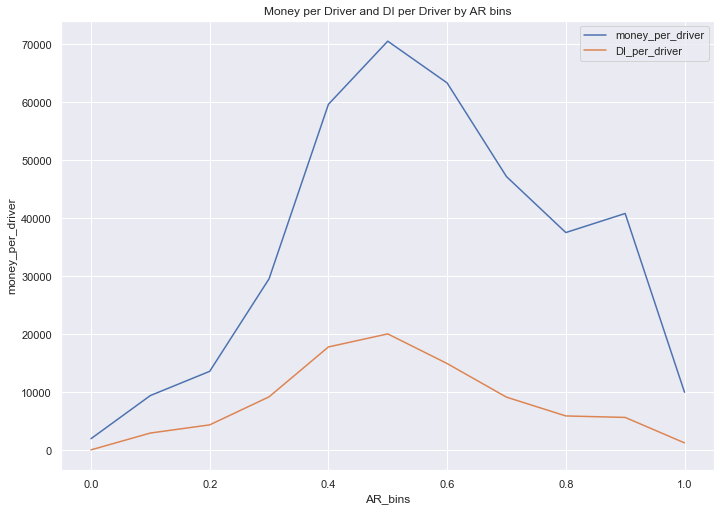

In [106]:
sns.lineplot(data=ttl_data, x="AR_bins", y="money_per_driver", label="money_per_driver")
sns.lineplot(data=ttl_data, x="AR_bins", y="DI_per_driver", label="DI_per_driver").set_title("Money per Driver and DI per Driver by AR bins")

In [107]:
x = ttl_data[['TPH','MPH']].values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_mph_tph = pd.DataFrame(x_scaled)

In [108]:
df_mph_tph['AR_bins'] = ttl_data.AR_bins
df_mph_tph.columns = ['TPH','MPH','AR_bins']

Text(0.5, 1.0, 'Normalized TPH & MPH')

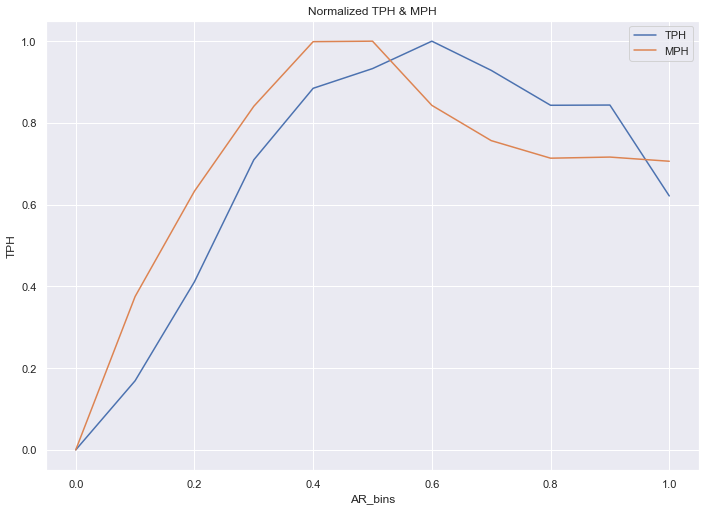

In [109]:
sns.lineplot(data=df_mph_tph, x="AR_bins", y="TPH", label="TPH")
sns.lineplot(data=df_mph_tph, x="AR_bins", y="MPH", label="MPH").set_title("Normalized TPH & MPH")

In [110]:
m_sh_v = ttl_data[['MONEY','SUPPLY_HOURS']].values
m_sh_v = min_max_scaler.fit_transform(m_sh_v)
m_sh = pd.DataFrame(m_sh_v)

In [111]:
m_sh['AR_bins'] = ttl_data.AR_bins
m_sh.columns = ['MONEY','SUPPLY_HOURS','AR_bins']

Text(0.5, 1.0, 'Money vs SH by AR bins')

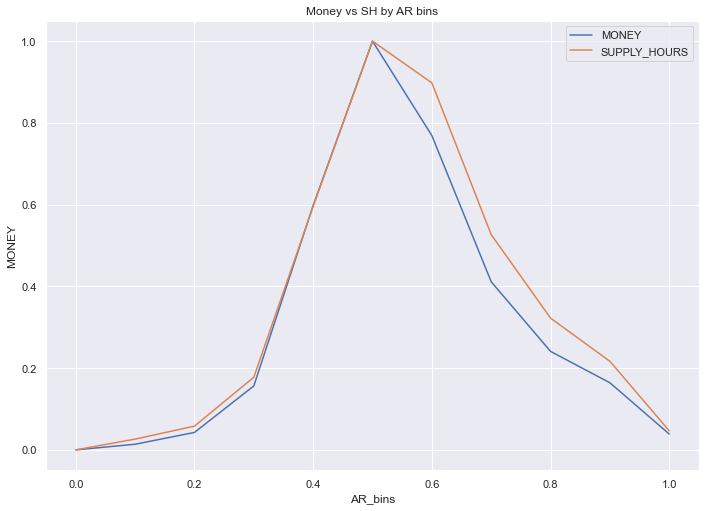

In [112]:
sns.lineplot(data=m_sh, x="AR_bins", y="MONEY", label="MONEY")
sns.lineplot(data=m_sh, x="AR_bins", y="SUPPLY_HOURS", label="SUPPLY_HOURS").set_title("Money vs SH by AR bins")

In [114]:
ttl_data[['AR_bins', 'DRIVER_RK', 'TPD', 'TPH', 'MPH', 'money_per_driver', 'DI_per_driver']]

,AR_bins,DRIVER_RK,TPD,TPH,MPH,money_per_driver,DI_per_driver
0,0.0,927,3.748652,0.118624,50.807511,1997.787485,71.059331
1,0.1,4568,26.729641,0.391677,265.051657,9431.347731,2970.362180
2,0.2,9529,40.673838,0.782949,412.269589,13605.604840,4378.958607
3,0.3,15936,90.623243,1.264828,530.867998,29547.430122,9207.820805
4,0.4,30099,163.684009,1.547527,621.166100,59611.247549,17806.434681
5,0.5,42550,206.895511,1.625382,621.844625,70496.214673,20054.263725
6,0.6,36447,233.447828,1.733753,532.161962,63303.583298,14948.531536
7,0.7,26183,175.826911,1.618426,482.904881,47166.179126,9156.296065
8,0.8,19300,129.978497,1.480444,458.354120,37518.885919,5916.794960
9,0.9,12106,135.236907,1.481342,459.903011,40804.567153,5661.797215


# Только Москва

In [115]:
msk_data = df[df['LOCALITY_NM']=='Москва'].groupby('AR_bins').agg({
    'DRIVER_RK':'count','TRIPS':'sum','MPH_GROSS':'median','MONEY':'sum','SUPPLY_HOURS':'sum',
    'TPH':'median','DI_TOTAL_AMT':'sum'}).reset_index()

In [116]:
msk_data['TPD'] = np.divide(msk_data['TRIPS'], msk_data['DRIVER_RK'])
msk_data['MPH'] = np.divide(msk_data['MONEY'], msk_data['SUPPLY_HOURS'])

Text(0.5, 1.0, 'MPH & TPD by AR bins, MSK only')

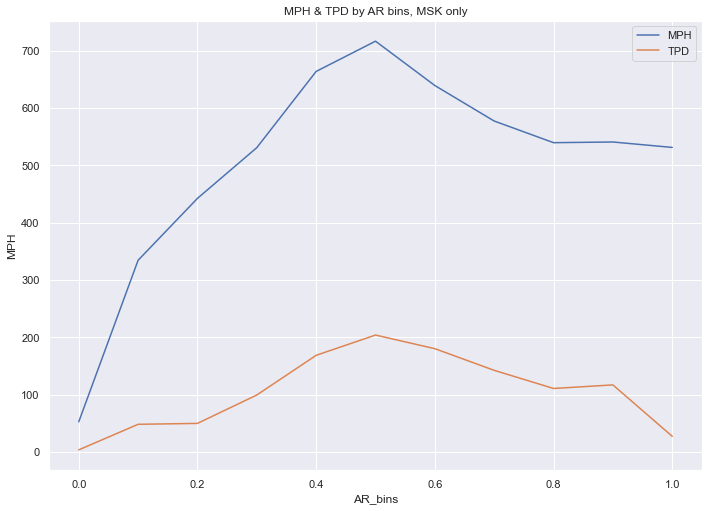

In [117]:
sns.lineplot(data=msk_data, x="AR_bins", y="MPH", label="MPH")
sns.lineplot(data=msk_data, x="AR_bins", y="TPD", label="TPD").set_title("MPH & TPD by AR bins, MSK only")

In [119]:
df.columns

Index(['LOCALITY_RK', 'LOCALITY_NM', 'DRIVER_RK', 'MONEY', 'SUPPLY_HOURS',
       'MPH_GROSS', 'TRIPS', 'TPH', 'ACCEPT', 'SUGGEST', 'AR', 'DI_TOTAL_AMT',
       'OPEN_STATE', 'EN_ROUTE_STATE', 'ON_TRIP_STATE', 'AR_bins'],
      dtype='object')

In [122]:
sh_data = df[['AR_bins', 'SUPPLY_HOURS', 'OPEN_STATE', 'EN_ROUTE_STATE', 'ON_TRIP_STATE'
             ]].groupby('AR_bins').sum().reset_index()

In [124]:
sh_data['open_share'] = np.divide(sh_data['OPEN_STATE'], sh_data['SUPPLY_HOURS'])
sh_data['enroute_share'] = np.divide(sh_data['EN_ROUTE_STATE'], sh_data['SUPPLY_HOURS'])
sh_data['ontrip_share'] = np.divide(sh_data['ON_TRIP_STATE'], sh_data['SUPPLY_HOURS'])

In [128]:
sh_data[['AR_bins', 'open_share', 'enroute_share', 'ontrip_share']]

,AR_bins,open_share,enroute_share,ontrip_share
0,0.0,0.886035,0.058172,0.055793
1,0.1,0.770826,0.068741,0.160433
2,0.2,0.592799,0.116929,0.290271
3,0.3,0.437039,0.140978,0.421983
4,0.4,0.344382,0.155926,0.499692
5,0.5,0.301337,0.169090,0.529573
6,0.6,0.280162,0.180588,0.539250
7,0.7,0.289268,0.181440,0.529293
8,0.8,0.293800,0.185594,0.520607
9,0.9,0.275569,0.191031,0.533400


Text(0.5, 1.0, 'Open, En-route and On-trip by AR bins')

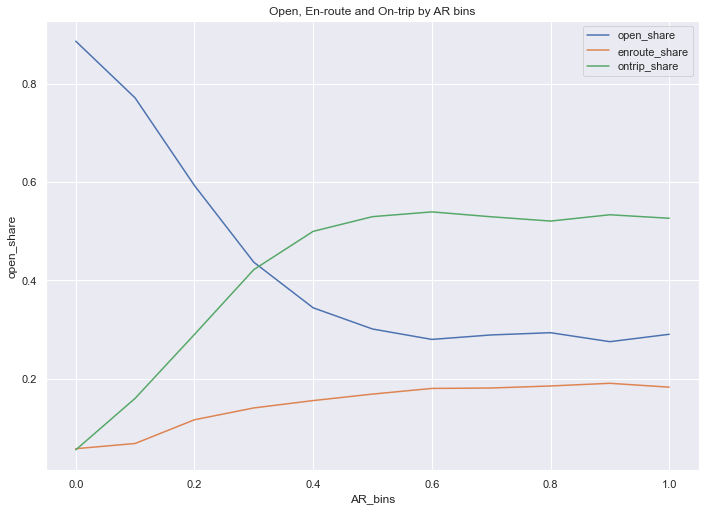

In [130]:
sns.lineplot(data=sh_data, x="AR_bins", y="open_share", label="open_share")
sns.lineplot(data=sh_data, x="AR_bins", y="enroute_share", label="enroute_share")
sns.lineplot(data=sh_data, x="AR_bins", y="ontrip_share", label="ontrip_share").set_title(
    "Open, En-route and On-trip by AR bins")

In [131]:
ttl_data

,AR_bins,DRIVER_RK,TRIPS,MPH_GROSS,MONEY,SUPPLY_HOURS,TPH,DI_TOTAL_AMT,TPH_upd,MPH,money_per_driver,DI_per_driver,TPD
0,0.0,927,3475.0,46.743352,1.851949e+06,3.645030e+04,0.118624,6.587200e+04,0.095335,50.807511,1997.787485,71.059331,3.748652
1,0.1,4568,122101.0,139.555716,4.308240e+07,1.625434e+05,0.391677,1.356861e+07,0.751190,265.051657,9431.347731,2970.362180,26.729641
2,0.2,9529,387581.0,257.772729,1.296478e+08,3.144734e+05,0.782949,4.172710e+07,1.232476,412.269589,13605.604840,4378.958607,40.673838
3,0.3,15936,1444172.0,425.526419,4.708678e+08,8.869773e+05,1.264828,1.467358e+08,1.628195,530.867998,29547.430122,9207.820805,90.623243
4,0.4,30099,4926725.0,538.720444,1.794239e+09,2.888501e+06,1.547527,5.359559e+08,1.705634,621.166100,59611.247549,17806.434681,163.684009
5,0.5,42550,8803404.0,513.972032,2.999614e+09,4.823735e+06,1.625382,8.533089e+08,1.825018,621.844625,70496.214673,20054.263725,206.895511
6,0.6,36447,8508473.0,463.853591,2.307226e+09,4.335570e+06,1.733753,5.448291e+08,1.962481,532.161962,63303.583298,14948.531536,233.447828
7,0.7,26183,4603676.0,419.775613,1.234952e+09,2.557340e+06,1.618426,2.397393e+08,1.800181,482.904881,47166.179126,9156.296065,175.826911
8,0.8,19300,2508585.0,396.127217,7.241145e+08,1.579815e+06,1.480444,1.141941e+08,1.587898,458.354120,37518.885919,5916.794960,129.978497
9,0.9,12106,1637178.0,403.201870,4.939801e+08,1.074096e+06,1.481342,6.854172e+07,1.524238,459.903011,40804.567153,5661.797215,135.236907


Text(0.5, 1.0, 'Drivers per Bucket')

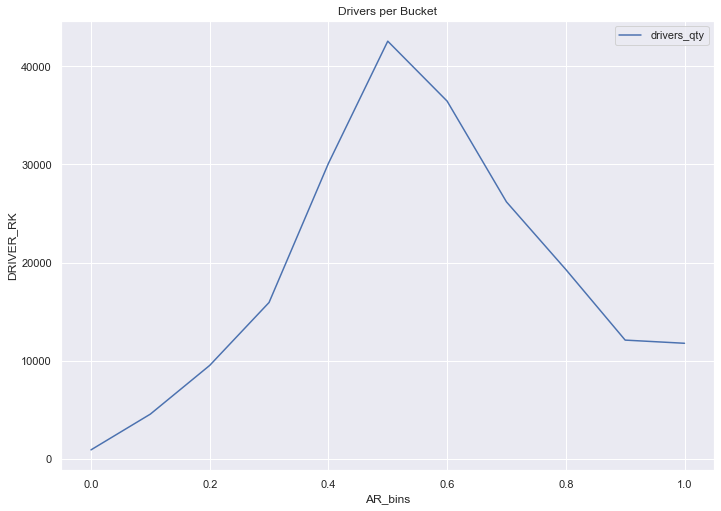

In [133]:
sns.lineplot(data=ttl_data, x="AR_bins", y="DRIVER_RK", label="drivers_qty").set_title(
    "Drivers per Bucket")